<a href="https://colab.research.google.com/github/Eric-Oliveira-ds/leishticIA/blob/dev/AlexNet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use pre-trained AlexNet to train and classifier leishmanioses and pyoderma images

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchviz

In [2]:
!pip install easy-explain

In [3]:
import torch
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageOps
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchviz import make_dot

## Utils

In [4]:
# Definir as transformações personalizadas
class RandomBrightnessContrast:
    def __init__(self, brightness=(0.9, 1.1), contrast=(0.9, 1.1)):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, img):
        if random.random() > 0.5:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(*self.brightness))
        if random.random() > 0.5:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(*self.contrast))
        return img

class RandomCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        if random.random() > 0.5:
            img = ImageOps.equalize(img)
        return img

In [113]:
class AlexNetGradCAM(nn.Module):
    def __init__(self):
        super(AlexNetGradCAM, self).__init__()

        # Carrega o modelo AlexNet pré-treinado
        self.alexnet = models.alexnet(pretrained=True)

        # Extrai as camadas convolucionais até a última camada de ativação desejada
        self.features_conv = self.alexnet.features[:12]

        # Extrai o classificador
        self.classifier = self.alexnet.classifier

        # Placeholder para os gradientes
        self.gradients = None

    # Hook para capturar os gradientes das ativações
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # Registra o hook na última camada convolucional
        h = x.register_hook(self.activations_hook)

        # Flatten e passa pelo classificador
        x = F.adaptive_avg_pool2d(x, (6, 6))  # Ajuste para o classificador da AlexNet
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    # Método para extrair os gradientes
    def get_activations_gradient(self):
        return self.gradients

    # Método para extrair as ativações
    def get_activations(self, x):
        return self.features_conv(x)

# Inicializa o modelo
model = AlexNetGradCAM()
model.eval()

# Função para aplicar o Grad-CAM
def generate_gradcam_heatmap(model, img_tensor, target_class=None):
    # Realiza a predição e captura o índice da classe
    pred = model(img_tensor)
    if target_class is None:
        target_class = pred.argmax(dim=1).item()

    # Calcula o gradiente da classe-alvo em relação à saída
    model.zero_grad()
    pred[:, target_class].backward()

    # Extrai o gradiente médio em cada canal da última camada convolucional
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Extrai as ativações da última camada convolucional
    activations = model.get_activations(img_tensor).detach()

    # Pondera as ativações pelo gradiente médio
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Calcula o heatmap médio nas ativações
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Aplica ReLU e normaliza
    heatmap = F.relu(heatmap)
    heatmap /= heatmap.max()
    return heatmap.numpy()

## Data Transformation

In [5]:
# Função para desnormalizar as imagens e converter para formato exibível
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Converte para formato HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormaliza
    img = np.clip(img, 0, 1)  # Limita os valores entre 0 e 1 para exibição
    plt.imshow(img)

In [6]:
# Definir as transformações para o dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        RandomBrightnessContrast(),
        RandomCLAHE(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
# Carregar os datasets de treino e teste
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/train/', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/test/', transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Visualize transformations

In [8]:
# Obter um lote de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

Imagem 0, Label: 2
Imagem 1, Label: 4
Imagem 2, Label: 4
Imagem 3, Label: 4
Imagem 4, Label: 4
Imagem 5, Label: 0
Imagem 6, Label: 4
Imagem 7, Label: 4


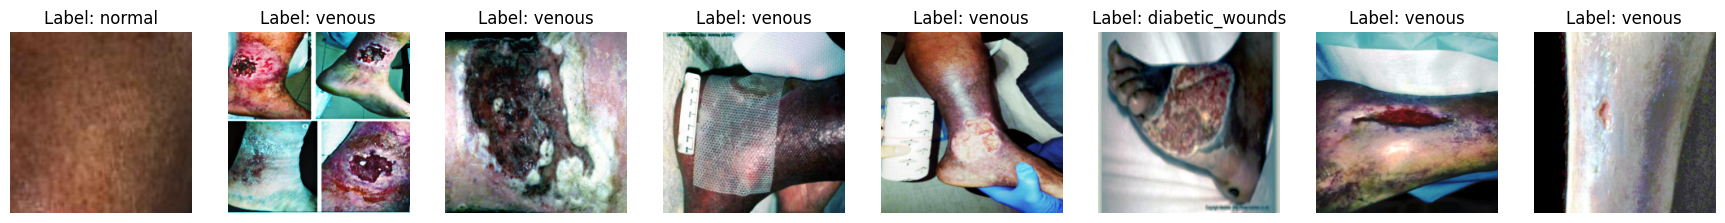

In [9]:
# Exibir as imagens com transformações
fig, axes = plt.subplots(1, len(images), figsize=(22, 10))
for i, img in enumerate(images):
    label_value = labels[i].item()
    print(f'Imagem {i}, Label: {label_value}')  # Mostra o valor do rótulo

    # Definir o rótulo baseado no valor
    if label_value == 0:
        label_text = 'diabetic_wounds'
    elif label_value == 1:
        label_text = 'leishmaniose'
    elif label_value == 2:
        label_text = 'normal'
    elif label_value == 3:
        label_text = 'pyoderma'
    elif label_value == 4:
        label_text = 'venous'
    else:
        label_text = 'unknown'

    ax = axes[i]
    ax.set_title(f"Label: {label_text}")
    ax.axis('off')
    plt.sca(ax)
    imshow(img)

plt.show()

In [11]:
train_loader.dataset.classes

['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

In [12]:
test_loader.dataset.classes

['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

In [13]:
print('length of train dataset: {}'.format(len(train_loader.dataset.samples)))

length of train dataset: 1261


In [14]:
print('length of test dataset: {}'.format(len(test_loader.dataset.samples)))

length of test dataset: 40


In [15]:
# Mapeamento de classes para índices
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

{'diabetic_wounds': 0, 'leishmaniose': 1, 'normal': 2, 'pyoderma': 3, 'venous': 4}


In [16]:
# Mapeamento de classes para índices
class_to_idx = test_dataset.class_to_idx
print(class_to_idx)

{'diabetic_wounds': 0, 'leishmaniose': 1, 'normal': 2, 'pyoderma': 3, 'venous': 4}


## Model Train

In [17]:
# Carregar o modelo AlexNet pré-treinado
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 102MB/s] 


In [18]:
# Congelar os parâmetros do modelo para evitar treinar toda a rede
for param in model.parameters():
    param.requires_grad = False

In [19]:
# Modificar a última camada para se ajustar ao número de classes do seu dataset
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [20]:
num_classes

5

In [21]:
# Definir o otimizador e a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [23]:
# Treinamento do modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
device

device(type='cpu')

In [25]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


In [31]:
sample_input = torch.randn(1, 3, 224, 224).to(device)  # Exemplo de entrada
y = model(sample_input)  # Passando o input pelo modelo
make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")

'model_architecture.png'

Epoch [1/50], Loss: 0.4622
Epoch [2/50], Loss: 0.2416
Epoch [3/50], Loss: 0.2057
Epoch [4/50], Loss: 0.2092
Epoch [5/50], Loss: 0.1762
Epoch [6/50], Loss: 0.1454
Epoch [7/50], Loss: 0.1510
Epoch [8/50], Loss: 0.1999
Epoch [9/50], Loss: 0.1330
Epoch [10/50], Loss: 0.1200
Epoch [11/50], Loss: 0.1418
Epoch [12/50], Loss: 0.1558
Epoch [13/50], Loss: 0.1250
Epoch [14/50], Loss: 0.1295
Epoch [15/50], Loss: 0.1049
Epoch [16/50], Loss: 0.1088
Epoch [17/50], Loss: 0.1157
Epoch [18/50], Loss: 0.1113
Epoch [19/50], Loss: 0.1318
Epoch [20/50], Loss: 0.0972
Epoch [21/50], Loss: 0.1192
Epoch [22/50], Loss: 0.0984
Epoch [23/50], Loss: 0.1002
Epoch [24/50], Loss: 0.0854
Epoch [25/50], Loss: 0.1055
Epoch [26/50], Loss: 0.1261
Epoch [27/50], Loss: 0.1259
Epoch [28/50], Loss: 0.0965
Epoch [29/50], Loss: 0.0928
Epoch [30/50], Loss: 0.0906
Epoch [31/50], Loss: 0.0910
Epoch [32/50], Loss: 0.0905
Epoch [33/50], Loss: 0.0796
Epoch [34/50], Loss: 0.0856
Epoch [35/50], Loss: 0.0793
Epoch [36/50], Loss: 0.1154
E

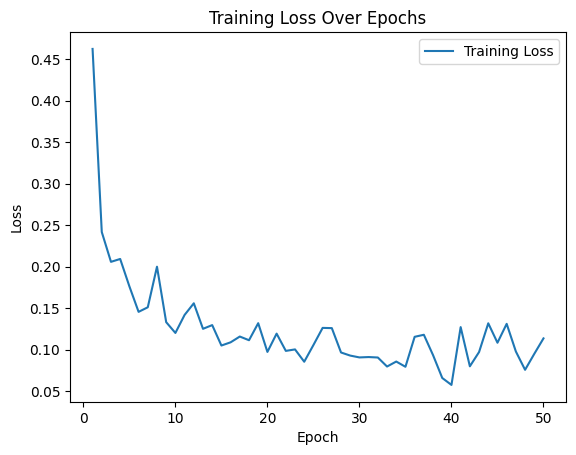

In [32]:
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Model Evatualion

In [33]:
# Avaliação do modelo
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # Armazene os rótulos e as previsões
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [34]:
print(f'Acurácia no conjunto de teste: {100 * correct / total:.2f}%')

Acurácia no conjunto de teste: 70.00%


In [35]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.12      0.22         8
           2       1.00      1.00      1.00         8
           3       0.57      0.50      0.53         8
           4       0.78      0.88      0.82         8

    accuracy                           0.70        40
   macro avg       0.78      0.70      0.65        40
weighted avg       0.78      0.70      0.65        40



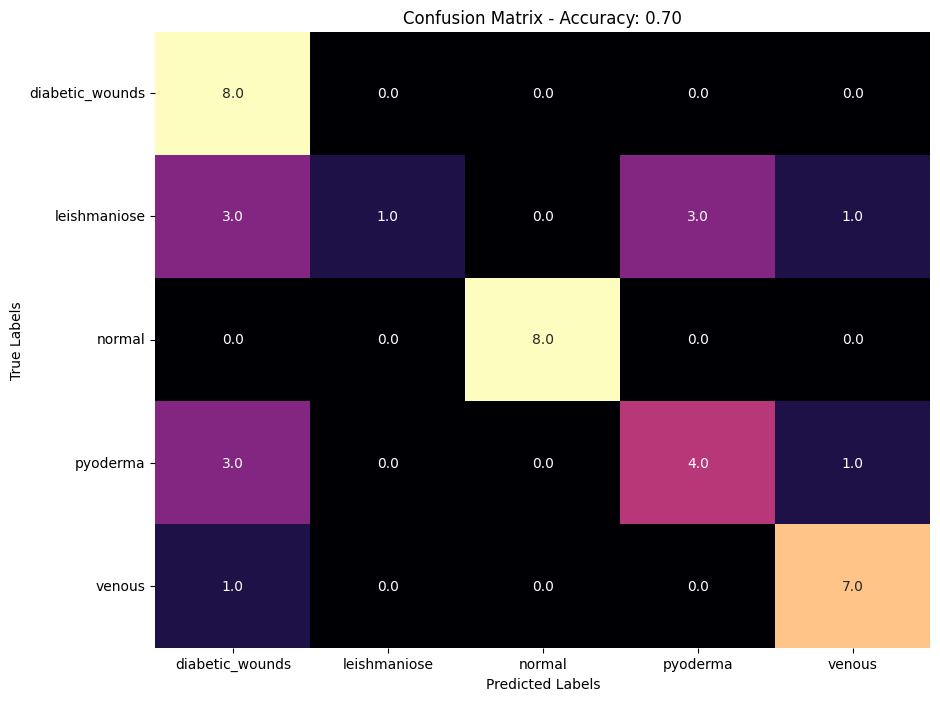

In [36]:
# Criar a matriz de confusão
cm = confusion_matrix(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

# Plotar a matriz de confusão com Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='.1f', cmap='magma', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.2f}')
ax.set_xticklabels(['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous'])
ax.set_yticklabels(['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous'], rotation=0)
plt.show()

## Model Deployment

In [37]:
# Salvar o modelo após o treinamento
torch.save(model.state_dict(), f'alexnet_acc_{accuracy:.2f}_weights.pth')

# Explainable AI

In [101]:
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.load_state_dict(torch.load(f'/content/alexnet_acc_{accuracy:.2f}_weights.pth'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

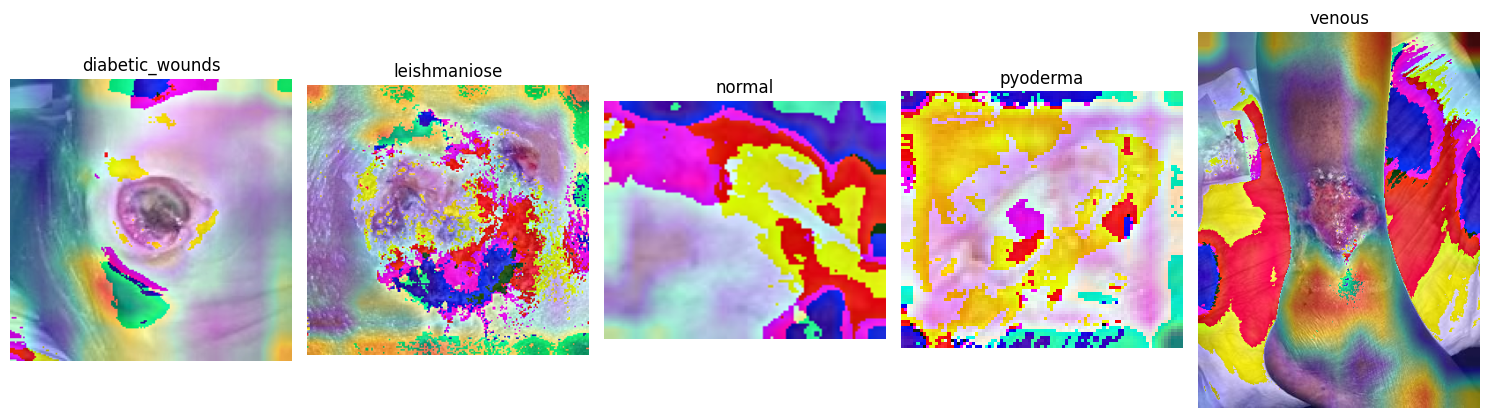

In [118]:
# Carregue uma imagem para teste
image_paths = ['/content/drive/MyDrive/dataset_classifier/test/diabetic_wounds/13_0.jpg',
               '/content/drive/MyDrive/dataset_classifier/test/leishmaniose/Imagem do WhatsApp de 2024-10-26 à(s) 20.39.03_041c824e.jpg',
               '/content/drive/MyDrive/dataset_classifier/test/normal/0711.jpg',
               '/content/drive/MyDrive/dataset_classifier/test/pyoderma/Imagem do WhatsApp de 2024-10-27 à(s) 17.12.33_ea46fe56.jpg',
               '/content/drive/MyDrive/dataset_classifier/test/venous/1558.jpg']

labels = ['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

# Pré-processamento das imagens
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Configura o layout dos subplots
n_rows = 1  # número de linhas
n_cols = 5  # número de colunas (ajuste conforme necessário)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Itera sobre as imagens e exibe com Grad-CAM
for i, (img_path, label) in enumerate(zip(image_paths, labels)):
    # Carrega e pré-processa a imagem
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)

    # Gera o heatmap Grad-CAM
    heatmap = generate_gradcam_heatmap(model, img_tensor)

    # Carrega a imagem original para sobrepor o heatmap
    img = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    jet_heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = jet_heatmap * 0.4 + img
    # Converte para uint8 antes de aplicar cvtColor
    superimposed_img = np.uint8(superimposed_img)
    # Converte para RGB para exibição com matplotlib
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Exibe a imagem com título da label
    axes[i].imshow(superimposed_img)
    axes[i].set_title(label)
    axes[i].axis('off')

# Ajusta o layout
plt.tight_layout()
plt.show()

Distribuição dos Mapas de Calor:

Diabetic Wounds: O modelo parece focar na área central, onde a lesão está mais concentrada. Isso faz sentido, pois a característica da imagem de uma ferida diabética geralmente está no centro da lesão.

Leishmaniose: O mapa de calor mostra atenção dispersa ao redor da área da ferida, o que pode fazer sentido dependendo da distribuição e dos detalhes da infecção.

Normal: A imagem "normal" tem um padrão de calor mais disperso, o que sugere que o modelo não encontrou uma área específica de lesão.

Pyoderma: O modelo foca em áreas aparentemente lesadas, mas o mapa de calor parece menos denso ou difuso. Isso pode indicar que o modelo está incerto sobre a classificação ou que a característica da lesão é menos evidente.

Venous: O modelo parece focar mais nas bordas e em áreas específicas da lesão. Isso pode fazer sentido para lesões venosas, que podem ter bordas irregulares e padrões específicos.